## Importing required libraries

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

## To download datasets from kaggle
import opendatasets as od

## For data loading and wrangling
import pandas as pd

## For matrix manipulation and plotting
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## For encoding labels to values instead of text
from sklearn.preprocessing import LabelEncoder

## Classification algorithm
from xgboost import XGBClassifier

## ADASYN for oversampling imbalanced dataset
from imblearn.over_sampling import ADASYN

## To split dataset into training and test sets
from sklearn.model_selection import train_test_split

## For conducting grid search and K-fold cross-validation in hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, KFold

## For computing RMSE, ROC AUC & Accuracy scores
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, accuracy_score

## Load Data

In [2]:
## Download bank customers churn dataset from kaggle
od.download("https://www.kaggle.com/datasets/santoshd3/bank-customers")

folder = os.path.join(os.getcwd(), 'bank-customers')
file = os.path.join(folder, [f for f in os.listdir(folder)][0])

Skipping, found downloaded files in ".\bank-customers" (use force=True to force download)


In [3]:
## Load dataset into a dataframe
df = pd.read_csv(file)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


From the df.info() output, we can take note on the following information:
- There are 13 features and 1 label columns in the dataset
- There are 10,000 rows in the dataset
- There are no null values in all of the dataset columns

as confirmed below:

In [5]:
print("Number of columns in dataset:", len(df.columns))

Number of columns in dataset: 14


In [6]:
print("Number of rows in dataset:", len(df))

Number of rows in dataset: 10000


In [7]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
any(df.duplicated())

False

In [9]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Some interesting things we can find from the data:
- RowNumber is an incremental unique ID, given to each row
- CustomerId is a unique ID given to each unique customer
- CreditScore ranges from 350 to 850, which complies with FICO credit scoring
- HasCrCard & IsActiveMember are boolean features

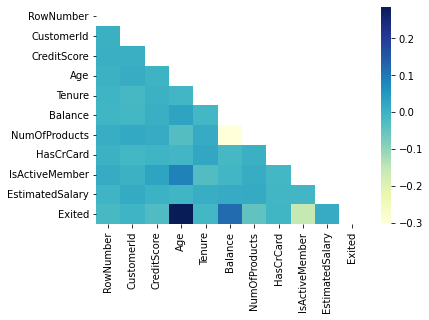

In [10]:
## Calculating correlation matrix of dataset
corr = df.corr(method='pearson')
mask = np.triu(np.ones(corr.shape)).astype(np.bool)
heatmap = sns.heatmap(corr, mask=mask, cmap="YlGnBu")

- Age is positively correlated with Exited
  - could mean that the older a customer gets, the more likely they are to close their account


- IsActiveMember is negatively correlated with Exited
  - possible that customers are more likely to close their accounts if their usage frequency is low
  
  
- Balance is negatively correlated with NumOfProducts
  - possible that owning a greater number of products would result in a lower balance, and the inverse may hold true as well

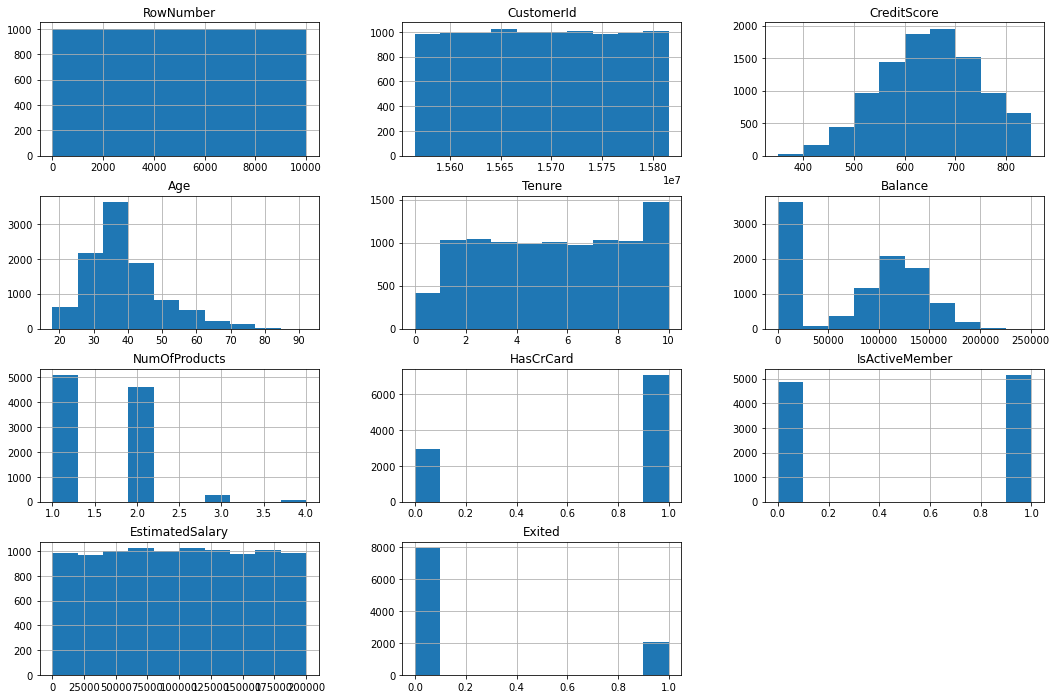

In [11]:
df.hist(figsize=(18,12))
plt.show()

In [12]:
# Remove redundant information
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [13]:
## Encode categorical columns

o_cols = df.select_dtypes('O').columns

for col in o_cols:
    print(df[col].value_counts(), '\n')

le = LabelEncoder()

for col in o_cols:
    df[col] = le.fit_transform(df[col])

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64 

Male      5457
Female    4543
Name: Gender, dtype: int64 



In [14]:
## Separate data to features and label

X = df.drop('Exited', axis=1)
y = df['Exited']

In [15]:
## Initial distribution of label classes
y.value_counts().sort_index()

0    7963
1    2037
Name: Exited, dtype: int64

In [16]:
## Can see that the dataset is imbalanced
## So, we use ADASYN to oversample the minority class
## ADASYN (Adaptive Synthetic) is an algorithm that generates synthetic data
#### its greatest advantages are not copying the same minority data, 
#### and generating more data for “harder to learn” examples.
## Can also use SMOTE or Borderline-SMOTE to balance the classes

oversample = ADASYN()
X, y = oversample.fit_resample(X, y)

In [17]:
## New distribution of label classes
y.value_counts().sort_index()

0    7963
1    7977
Name: Exited, dtype: int64

In [18]:
## Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)

## Make predictions for test data
y_pred = model.predict(X_test)

## Compute accuracy and RMSE between actual vs predicted values
accuracy_score(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False)

[14:00:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.857172731074864, 0.3779249514455693)

In [19]:
## Hyperparameter tuning

params = {'max_depth': [3, 5, 6, 10, 15, 20],
          'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
          'booster': ['gbtree', 'gblinear'],
          'gamma': [0, 0.5, 1],
          'reg_alpha': [0, 0.5, 1],
          'reg_lambda': [0.5, 1, 5],
          'base_score': [0.2, 0.5, 1],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.4, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'n_estimators': [100, 200, 500, 1000]}

xgbc = XGBClassifier(n_jobs=-1)
clf = RandomizedSearchCV(estimator=xgbc, 
                   param_distributions=params,
                   n_iter=100,
                   n_jobs=-1,
                   scoring='neg_mean_squared_error', 
                   random_state=0,
                   verbose=1)

clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[14:03:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters: {'subsample': 0.8999999999999999, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.7, 'booster': 'gbtree', 'base_score': 0.2}
Lowest RMSE:  0.35765512642834685


In [20]:
clf.best_params_

{'subsample': 0.8999999999999999,
 'reg_lambda': 5,
 'reg_alpha': 0.5,
 'n_estimators': 1000,
 'max_depth': 15,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 0.8999999999999999,
 'colsample_bylevel': 0.7,
 'booster': 'gbtree',
 'base_score': 0.2}

In [21]:
## Build new model based on tuned hyperparameters

best_model = XGBClassifier(n_jobs=-1)
best_model.set_params(**clf.best_params_, )
best_model.fit(X_train, y_train)

## Make predictions for test data
y_pred = best_model.predict(X_test)

## Compute accuracy and RMSE between actual vs predicted values
accuracy_score(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False)

[14:03:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.8747386030949393, 0.3539228685816454)

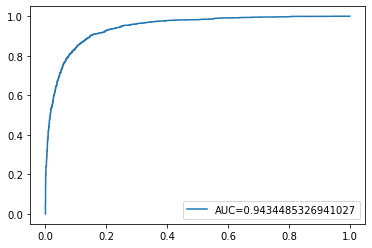

In [22]:
## Plot of best model ROC
y_pred_proba = best_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()